Non-bayesian

In [1]:
import os
def return_package_path():
    cwd = os.getcwd()
    idx = cwd.find("goalscorers-project") + len("goalscorers-project") + 1
    return cwd[:idx] + "goalscorers-private/"
package_paths = [return_package_path()]
import sys
for path in package_paths:
    sys.path.append(path)
import goalscorer_package.constants as c
import goalscorer_package.data_cleaning as dc
import goalscorer_package.modelling as m
import datetime as dt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import GammaRegressor
# import pymc as pm
# print(f"Running on PyMC v{pm.__version__}")
# import arviz as az
# print(f"Running on Az v{az.__version__}")
# import pytensor.tensor as pt
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import glob
from statistics import mode
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 1000)
pd.set_option("display.max_colwidth", 100)
pd.options.display.float_format = "{: ,.3f}".format
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 6)
%config InlineBackend.figure_formats = ["retina"]

In [2]:
TUNE = False
TEST = True

# Data

In [3]:
seasons = ["2017-2018", "2018-2019", "2019-2020", "2020-2021"]
# comp_ids = [9, 10, 11, 12, 13, 20]
comp_ids = [9, 11, 12, 13, 20]

In [4]:
target_variable = "npxg"

In [5]:
def data(seasons: list[str], comp_ids: list[int]) -> pd.DataFrame:
    seasons_leagues = dc.get_seasons_leagues_from_str(seasons, comp_ids)
    df_exp = (
        dc.load_match_expectancies_df(seasons_leagues)
        .assign(date=lambda x: x.datetime.dt.date)
        .drop(columns=["datetime"])
    )
    df = dc.load_seasons_leagues_files("summary", True, seasons_leagues)
    df = dc.split_positions(df)
    df = dc.position_to_generic_position(df)
    df = dc.add_frac_90(df)
    df = dc.add_home(df)
    df = dc.add_opp_team(df)
    df = dc.drop_na_npxg(df)
    df = dc.drop_na_frac_90(df)
    df = dc.drop_gk(df)
    df = dc.add_npg(df)
    df = dc.add_league(df)
    df["season"] = np.vectorize(lambda x: x.season)(df.season_league)
    df = dc.add_datetime(df)
    df = dc.add_expectancies(df, df_exp)
    df = df.dropna(subset=["team_exp"], ignore_index=True)  # drop playoff games
    df = df.assign(
        team_supremacy=lambda x: x.team_exp - x.opp_team_exp,
        npxg=lambda x: np.where(x.npxg == 0.0, 0.0001, x.npxg),
    )
    df = dc.add_match_number(df)
    df = dc.add_t(df, 76)
    return df

In [6]:
def ohe(df_model: pd.DataFrame) -> pd.DataFrame:
    categorical_columns = ["player_id", "opposition_team", "position", "league", "squad"]
    return (
        df_model
        .join(pd.get_dummies(df_model[categorical_columns].astype(str), dtype=int))
        .assign(constant=1)
    )

In [7]:
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    features = [
        "constant",
        "home",
        "ln_frac_90_start",
        "ln_frac_90_not_start",
        "ln_team_exp",
        "team_supremacy",
        "team_supremacy_2",
    ] + [
        f"player_id_{player_id}" for player_id in df.player_id.unique()
    ] + [
        f"opposition_team_{opposition_team}" for opposition_team in df.opposition_team.unique()
    ] + [
        f"position_{position}" for position in df.position.unique()
    ] + [
        f"league_{league}" for league in df.league.unique()
    ] + [
        f"squad_{squad}" for squad in df.squad.unique()
    ]
    return features

In [8]:
df = data(seasons, comp_ids)

In [9]:
df.head()

,home_team,away_team,datetime,shirtnumber,nationality,position,age,minutes,goals,assists,pens_made,pens_att,shots,shots_on_target,cards_yellow,cards_red,touches,tackles,interceptions,blocks,xg,npxg,xg_assist,sca,gca,passes_completed,passes,passes_pct,progressive_passes,carries,progressive_carries,take_ons,take_ons_won,player_id,player,squad,start,season_league,position_0,position_1,position_2,position_3,position_4,complex_position,frac_90,home,opposition_team,npg,league,season,epoch_datetime,date,team_home,team_away,home_exp,away_exp,success,error,team_exp,opp_team_exp,team_supremacy,match_number,time_interval,t
0,Monaco,Toulouse,2017-08-04 18:45:00,6,fr FRA,CB,24-135,90.000,0,0,0,0,0,0,0,0,32.000,2.000,3,1.000,0.000,0.000,0.000,0.000,0.000,9.000,14.000,64.300,0.000,7.000,0.000,0.000,0.000,f323d995,Christopher Jullien,Toulouse,True,Ligue-1 2017-2018,CB,None,None,None,None,CB,1.000,0,Monaco,0,13,Season 2017-2018 across 2 years,1501872300,2017-08-04,Monaco,Toulouse,2.356,0.709,True,0.000,0.709,2.356,-1.647,1,"(0.999, 98.0]",1
1,Monaco,Toulouse,2017-08-04 18:45:00,20,bf BFA,CB,24-231,90.000,0,0,0,0,0,0,0,0,15.000,0.000,2,2.000,0.000,0.000,0.000,0.000,0.000,7.000,7.000,100.000,0.000,6.000,0.000,1.000,1.000,7f9111ea,Steeve Yago,Toulouse,True,Ligue-1 2017-2018,CB,None,None,None,None,CB,1.000,0,Monaco,0,13,Season 2017-2018 across 2 years,1501872300,2017-08-04,Monaco,Toulouse,2.356,0.709,True,0.000,0.709,2.356,-1.647,1,"(0.999, 98.0]",1
2,Monaco,Toulouse,2017-08-04 18:45:00,27,fr FRA,CM,20-322,90.000,0,0,0,0,0,0,0,0,23.000,3.000,2,2.000,0.000,0.000,0.000,1.000,0.000,11.000,16.000,68.800,1.000,9.000,0.000,0.000,0.000,c69ef855,Alexis Blin,Toulouse,True,Ligue-1 2017-2018,CM,None,None,None,None,CM,1.000,0,Monaco,0,13,Season 2017-2018 across 2 years,1501872300,2017-08-04,Monaco,Toulouse,2.356,0.709,True,0.000,0.709,2.356,-1.647,1,"(0.999, 98.0]",1
3,Monaco,Toulouse,2017-08-04 18:45:00,29,ch SUI,FB,27-044,90.000,0,0,0,0,0,0,1,0,36.000,2.000,0,2.000,0.000,0.000,0.000,0.000,0.000,9.000,24.000,37.500,0.000,12.000,1.000,1.000,1.000,6ca88b2a,François Moubandje,Toulouse,True,Ligue-1 2017-2018,LB,None,None,None,None,LB,1.000,0,Monaco,0,13,Season 2017-2018 across 2 years,1501872300,2017-08-04,Monaco,Toulouse,2.356,0.709,True,0.000,0.709,2.356,-1.647,1,"(0.999, 98.0]",1
4,Monaco,Toulouse,2017-08-04 18:45:00,2,fr FRA,FB,19-177,90.000,0,0,0,0,0,0,0,0,29.000,0.000,1,0.000,0.000,0.000,0.000,0.000,0.000,18.000,21.000,85.700,1.000,7.000,0.000,0.000,0.000,bcc81786,Kelvin Amian,Toulouse,True,Ligue-1 2017-2018,RB,None,None,None,None,RB,1.000,0,Monaco,0,13,Season 2017-2018 across 2 years,1501872300,2017-08-04,Monaco,Toulouse,2.356,0.709,True,0.000,0.709,2.356,-1.647,1,"(0.999, 98.0]",1


In [10]:
df_model = df[["npxg", "npg", "player_id", "home", "opposition_team", "frac_90", "position", "league", "squad", "team_exp", "team_supremacy", "t", 
               "start", "datetime", "season", "home_team", "away_team"]].copy()
df_model = (
    ohe(df_model)
    .assign(
        days_ago=lambda x: (x.datetime.max() - x.datetime).dt.days,
        seasons_ago=lambda x: abs(x.season - x.season.max()).astype(int),
    )
    .assign(
        ln_frac_90=lambda x: np.log(x.frac_90),
        ln_frac_90_start=lambda x: x.ln_frac_90 * x.start,
        ln_frac_90_not_start=lambda x: x.ln_frac_90 * (1.0 - x.start),
        ln_team_exp=lambda x: np.log(x.team_exp),
        team_supremacy_2=lambda x: x.team_supremacy ** 2,
    )
)

df_model.head()

npxg  npg player_id  home opposition_team  frac_90 position  league  \
0  0.000    0  f323d995     0          Monaco    1.000       CB      13   
1  0.000    0  7f9111ea     0          Monaco    1.000       CB      13   
2  0.000    0  c69ef855     0          Monaco    1.000       CM      13   
3  0.000    0  6ca88b2a     0          Monaco    1.000       FB      13   
4  0.000    0  bcc81786     0          Monaco    1.000       FB      13   

      squad  team_exp  team_supremacy  t  start            datetime  \
0  Toulouse     0.709          -1.647  1   True 2017-08-04 18:45:00   
1  Toulouse     0.709          -1.647  1   True 2017-08-04 18:45:00   
2  Toulouse     0.709          -1.647  1   True 2017-08-04 18:45:00   
3  Toulouse     0.709          -1.647  1   True 2017-08-04 18:45:00   
4  Toulouse     0.709          -1.647  1   True 2017-08-04 18:45:00   

                            season home_team away_team  player_id_0000acda  \
0  Season 2017-2018 across 2 years    Monaco  Toulouse                   0   
1  Season 2017-2018 across 2 years    Monaco  Toulouse                   0   
2  Season 2017-2018 across 2 years    Monaco  Toulouse                   0   
3  Season 2017-2018 across 2 years    Monaco  Toulouse                   0   
4  Season 2017-2018 across 2 years    Monaco  Toulouse                   0   

   player_id_000b3da6  player_id_00242715  player_id_00242b75  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   player_id_0033fb1b  player_id_003a5c72  player_id_00459419  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   player_id_0049d544  player_id_004d185e  player_id_00528660  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   player_id_005c0807  player_id_0076ab7f  player_id_007b39a5  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   player_id_007faf7a  player_id_00823e9a  player_id_00844823  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   player_id_008a6e6d  player_id_00963611  player_id_009a4f60  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   player_id_00a6485f  player_id_00b0bb87  player_id_00b28772  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0          

In [11]:
df_model_train, df_model_test = train_test_split(df_model, train_size=0.7, shuffle=False)

# Hyperparameter Tune

In [12]:
def add_weights(df: pd.DataFrame, time_decay_factor: float, season_decay_factor: float) -> pd.DataFrame:
    time_decay = np.exp(-time_decay_factor * df.days_ago)
    season_decay = np.exp(-season_decay_factor * df.seasons_ago)
    game_time_weight = df.frac_90
    # game_time_weight = game_time_factor_1 * df.frac_90 + game_time_factor_2 * (df.frac_90 ** 2)
    return df.assign(weight=time_decay * season_decay * game_time_weight)

In [13]:
def add_ll(df: pd.DataFrame) -> pd.DataFrame:
    return df.assign(
        exponential_ll=lambda x: np.maximum(-10_000.0, np.log(scipy.stats.expon.pdf(x.npxg, scale=x.pred_npxg))),
        poisson_ll=lambda x: np.log(scipy.stats.poisson.pmf(x.npg, mu=x.pred_npxg))
    )

In [14]:
_, df_model_tune_test = train_test_split(df_model_train, train_size=0.7, shuffle=False)
tune_ts = df_model_tune_test.t.unique()

In [15]:
time_decay_factors = [0.01, 0.001, 0.0001, 0.0001, 0.0]
season_decay_factors = [1.0, 0.3, 0.1, 0.05, 0.01, 0.0]
regularisation_parameters = [0.001, 0.005, 0.01, 0.05, 0.1]

In [16]:
def predict(ts: list[int], df_model: pd.DataFrame, time_decay_factor: float, season_decay_factor: float, 
            regularisation_parameter: float) -> tuple[pd.DataFrame, GammaRegressor]:
    df_test_preds = []

    counter = 1
    # t = ts[0]
    # ts = ts[:2]
    for t in ts:
        # train test split
        df_train, df_test = df_model.query("t < @t"), df_model.query("t == @t")
        
        # add weights
        df_train = add_weights(df_train, time_decay_factor, season_decay_factor)
        
        # standardise train and test
        columns_to_standardise = ["team_exp", "ln_team_exp", "team_supremacy", "team_supremacy_2"]
        scaler = StandardScaler()
        scaler.fit(df_train[columns_to_standardise])
        df_train[columns_to_standardise], df_test[columns_to_standardise] = (
            scaler.transform(df_train[columns_to_standardise]),
            scaler.transform(df_test[columns_to_standardise])
            )

        # create X, y
        features = create_features(df_model)
        X_train, X_test = df_train[features], df_test[features]
        y_train, y_test = df_train[target_variable], df_test[target_variable]
        
        # train model
        model = GammaRegressor(max_iter=10_000, fit_intercept=False, alpha=regularisation_parameter)
        model.fit(X_train, y_train, sample_weight=df_train.weight)
        
        # test model
        df_test = df_test.assign(pred_npxg=model.predict(X_test))
        df_test_preds.append(df_test[["pred_npxg", "player_id", "home_team", "away_team", "datetime"]])
    
        print("Finished", counter, "/", len(ts))
        counter += 1

    df_test_pred = (
    pd
    .concat(df_test_preds, ignore_index=True)
    .merge(
        df[["player_id", "home_team", "away_team", "datetime", "npxg", "npg", "start"]], 
        how="left", 
        on=["player_id", "home_team", "away_team", "datetime"], 
        validate="1:1"
    )
    )
    df_test_pred = add_ll(df_test_pred)
    return df_test_pred, model

In [17]:
counter = 0

if TUNE:
    list_tuning_results = []
    for time_decay_factor in time_decay_factors:
        for season_decay_factor in season_decay_factors:
            for regularisation_parameter in regularisation_parameters:
                df_test_pred, model = predict(tune_ts, df_model_train, time_decay_factor, season_decay_factor, regularisation_parameter)
                list_tuning_results.append({
                    "time_decay_factor": time_decay_factor,
                    "season_decay_factor": season_decay_factor,
                    "regularisation_parameter": regularisation_parameter,
                    "exponential_ll": df_test_pred.query("start").exponential_ll.sum(),
                    "poisson_ll": df_test_pred.query("start").poisson_ll.sum(),
                    "model": model,
                })

                # Print number of parameter combos attempted
                print("FINISHED",
                    counter, "/",
                    (
                        len(time_decay_factors) * 
                        len(season_decay_factors) * 
                        len(regularisation_parameters) * 
                        1 
                    )
                     )
                counter += 1

In [18]:
if TUNE:
    df_tuning_results = pd.DataFrame(list_tuning_results).sort_values("exponential_ll", ignore_index=True, ascending=False)
    df_tuning_results.to_pickle("df_tuning_results.pickle")

else:
    df_tuning_results = pd.read_pickle("df_tuning_results.pickle")
    
df_tuning_results

,time_decay_factor,season_decay_factor,regularisation_parameter,exponential_ll,poisson_ll,model
0,0.001,0.300,0.001,"49,803.541","-9,520.375","GammaRegressor(alpha=0.001, fit_intercept=False, max_iter=10000)"
1,0.000,1.000,0.001,"49,790.866","-9,524.705","GammaRegressor(alpha=0.001, fit_intercept=False, max_iter=10000)"
2,0.000,1.000,0.001,"49,788.621","-9,525.160","GammaRegressor(alpha=0.001, fit_intercept=False, max_iter=10000)"
3,0.000,1.000,0.001,"49,788.621","-9,525.160","GammaRegressor(alpha=0.001, fit_intercept=False, max_iter=10000)"
4,0.001,0.100,0.001,"49,775.829","-9,520.292","GammaRegressor(alpha=0.001, fit_intercept=False, max_iter=10000)"
5,0.001,0.050,0.001,"49,766.362","-9,520.493","GammaRegressor(alpha=0.001, fit_intercept=False, max_iter=10000)"
6,0.001,0.010,0.001,"49,757.878","-9,520.571","GammaRegressor(alpha=0.001, fit_intercept=False, max_iter=10000)"
7,0.001,0.000,0.001,"49,755.872","-9,520.502","GammaRegressor(alpha=0.001, fit_intercept=False, max_iter=10000)"
8,0.000,0.300,0.001,"49,749.571","-9,521.095","GammaRegressor(alpha=0.001, fit_intercept=False, max_iter=10000)"
9,0.000,0.300,0.001,"49,749.571","-9,521.095","GammaRegressor(alpha=0.001, fit_intercept=False, max_iter=10000)"


# Fit

In [19]:
time_decay_factor = 0.001
season_decay_factor = 0.3
regularisation_parameter = 0.001

In [20]:
if TEST:
    test_ts = df_model_test.t.unique()
    df_test_pred, model = predict(test_ts, df_model, time_decay_factor, season_decay_factor, regularisation_parameter)

C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 1 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 2 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 3 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 4 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 5 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 6 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 7 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 8 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 9 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 10 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 11 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 12 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 13 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 14 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 15 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 16 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 17 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 18 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 19 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 20 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 21 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 22 / 23


C:\Users\benja\AppData\Local\Temp\ipykernel_15508\2874606610.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train[columns_to_standardise], df_test[columns_to_standardise] = (


Finished 23 / 23


# Coefficients

In [21]:
df_coefficients = pd.DataFrame((model.coef_.T))
df_coefficients.index = create_features(df_model)
df_coefficients.columns = ["coefficient"]
df_coefficients

,coefficient
constant,-1.891
home,0.059
ln_frac_90,0.770
ln_team_exp,0.171
team_supremacy,0.057
...,...
squad_Leeds United,0.236
squad_Cádiz,-0.059
squad_Arminia,-0.265
squad_Elche,-0.133


In [34]:
df_coefficients.loc[[col for col in df_coefficients.index if col.startswith("opp")]]

,coefficient
opposition_team_Monaco,-0.107
opposition_team_Toulouse,0.050
opposition_team_Paris Saint-Germain,0.038
opposition_team_Amiens,-0.030
opposition_team_Lyon,0.020
opposition_team_Strasbourg,0.029
opposition_team_Metz,-0.036
opposition_team_Guingamp,-0.060
opposition_team_Montpellier,0.111
opposition_team_Caen,0.050


# Predictions

In [22]:
df_pred = (
    df_test_pred
    [["player_id", "home_team", "away_team", "datetime", "pred_npxg", "exponential_ll", "poisson_ll"]]
    .merge(df, how="left", on=["player_id", "home_team", "away_team", "datetime"])
)

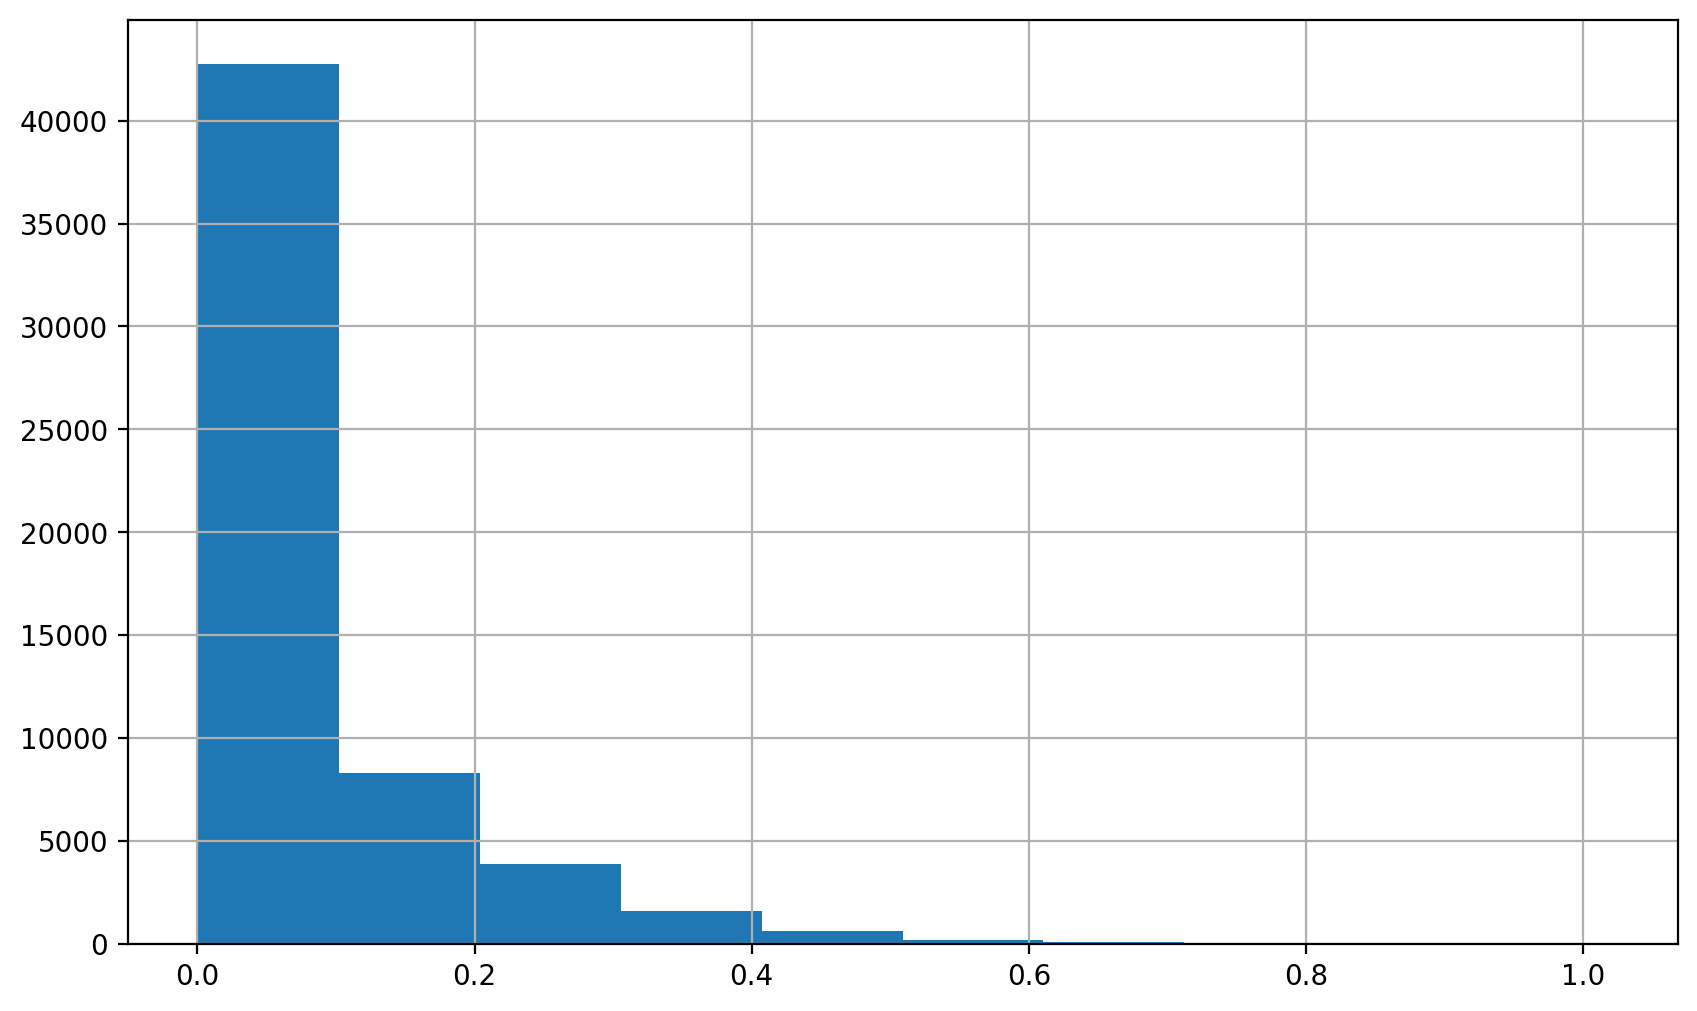

In [23]:
df_pred.pred_npxg.hist();

In [24]:
df_player_predictions = (
    df_pred
    .groupby("player_id", as_index=False)
    .agg(
        total_minutes=("minutes", sum),
        total_npxg=("npxg", sum),
        total_pred_npxg=("pred_npxg", sum),
    )
    .assign(
        npxg90=lambda x: (x.total_npxg / x.total_minutes) * 90.0,
        pred_npxg90=lambda x: (x.total_pred_npxg / x.total_minutes) * 90.0,
    )
    .merge(
        (
            df_coefficients
            .loc[[idx for idx in df_coefficients.index if idx.startswith("player_id_")]]
            .assign(
                player_id=lambda x: x.index,
                e_coefficient=lambda x: np.exp(x.coefficient),
            )
            .assign(player_id=lambda x: x.player_id.str[len("player_id_"):])
        )
    )
    .merge(df[["player_id", "player"]].drop_duplicates(), how="left", on=["player_id"])
)
df_player_predictions

,player_id,total_minutes,total_npxg,total_pred_npxg,npxg90,pred_npxg90,coefficient,e_coefficient,player
0,0000acda,59.000,0.000,0.123,0.000,0.188,0.121,1.129,Marco Benassi
1,00242715,"2,866.000",1.503,1.411,0.047,0.044,0.041,1.042,Moussa Niakhate
2,00242b75,"2,303.000",4.301,1.851,0.168,0.072,0.304,1.356,Leandro Barreiro Martins
3,0033fb1b,"1,799.000",3.702,3.025,0.185,0.151,0.086,1.090,Niclas Eliasson
4,004d185e,"2,019.000",1.602,1.954,0.071,0.087,-0.045,0.956,Tete Morente
...,...,...,...,...,...,...,...,...,...
2752,ffacd3d5,"1,198.000",0.202,0.424,0.015,0.032,-0.124,0.883,Manu Sánchez
2753,ffad706e,89.000,0.000,0.017,0.000,0.017,-0.099,0.906,Javi López
2754,ffbbc83b,"1,879.000",2.502,1.690,0.120,0.081,0.033,1.033,Florian Grillitsch
2755,ffec9769,599.000,3.901,3.012,0.586,0.453,0.085,1.088,Islam Slimani


In [25]:
player = "Robert Lewandowski"

df_player_predictions.query("player == @player")

,player_id,total_minutes,total_npxg,total_pred_npxg,npxg90,pred_npxg90,coefficient,e_coefficient,player
1550,8d78e732,"2,458.000",23.900,18.152,0.875,0.665,0.254,1.289,Robert Lewandowski


# Likelihood

In [26]:
df_test_set = (
    df_pred.query("start")
    .reset_index(drop=True)
    .assign(mse=lambda x: (x.pred_npxg - x.npxg) ** 2)
)

In [27]:
print(f"Number of predictions = {len(df_test_set): ,}")
print("Leagues: ", *df_test_set.league.unique())
print("Dates (inclusive): ", df_test_set.datetime.min(), " to ", df_test_set.datetime.max(), "\n")

print(f"Exponential log likelihood = {df_test_set['exponential_ll'].sum(): ,.2f}")
print(f"Poisson log likelihood = {df_test_set['poisson_ll'].sum(): ,.2f}")
print(f"MSE = {df_test_set['mse'].mean(): .5f}")
print(f"Average Exponential likelihood = {np.exp(df_test_set.exponential_ll.mean()): .3f}")
print(f"Average Poisson likelihood = {np.exp(df_test_set.poisson_ll.mean()): .3f}")

Number of predictions =  41,266
Leagues:  12 11 9 13 20
Dates (inclusive):  2020-06-27 20:00:00  to  2021-05-23 19:00:00 

Exponential log likelihood =  69,259.25
Poisson log likelihood = -12,514.68
MSE =  0.03224
Average Exponential likelihood =  5.357
Average Poisson likelihood =  0.738


In [28]:
position = "FW"
df_position = df_test_set.query("position == @position").reset_index(drop=True)
print(f"Number of predictions = {len(df_position): ,}")
print(f"Exponential log likelihood = {df_position['exponential_ll'].sum(): ,.2f}")
print(f"Poisson log likelihood = {df_position['poisson_ll'].sum(): ,.2f}")
print(f"MSE = {df_position['mse'].mean(): .5f}")
print(f"Average Exponential likelihood = {np.exp(df_position.exponential_ll.mean()): .3f}")
print(f"Average Poisson likelihood = {np.exp(df_position.poisson_ll.mean()): .3f}")

Number of predictions =  5,934
Exponential log likelihood =  2,004.99
Poisson log likelihood = -3,864.59
MSE =  0.10221
Average Exponential likelihood =  1.402
Average Poisson likelihood =  0.521


In [29]:
player_id = "87935cf3"
df_player = df_test_set.query("player_id == @player_id").reset_index(drop=True)
print(f"Number of predictions = {len(df_player)}")
print(f"Exponential log likelihood = {df_player['exponential_ll'].sum(): ,.2f}")
print(f"Poisson log likelihood = {df_player['poisson_ll'].sum(): ,.2f}")
print(f"MSE = {df_player['mse'].mean(): .5f}")
print(f"Average Exponential likelihood = {np.exp(df_player.exponential_ll.mean()): .3f}")
print(f"Average Poisson likelihood = {np.exp(df_player.poisson_ll.mean()): .3f}")

Number of predictions = 7
Exponential log likelihood =  22.19
Poisson log likelihood = -0.17
MSE =  0.00147
Average Exponential likelihood =  23.805
Average Poisson likelihood =  0.976


In [30]:
df_test_set[["player", "player_id", "t", "position", "home", "home_team", "away_team", "frac_90", "pred_npxg", "npxg"]]

,player,player_id,t,position,home,home_team,away_team,frac_90,pred_npxg,npxg
0,Rodrigo Ely,fd47b4f2,54,CB,0,Atlético Madrid,Alavés,1.000,0.022,0.000
1,Tachi,8b625720,54,CB,0,Atlético Madrid,Alavés,1.000,0.023,0.000
2,Pere Pons,29b61deb,54,CM,0,Atlético Madrid,Alavés,0.856,0.024,0.000
3,Abdallahi Mahmoud,ab99e4a0,54,CM,0,Atlético Madrid,Alavés,1.000,0.034,0.000
4,Ljubomir Fejsa,874d7a32,54,DM,0,Atlético Madrid,Alavés,1.000,0.023,0.000
...,...,...,...,...,...,...,...,...,...,...
41261,Adrien Thomasson,c76b7567,76,CM,1,Strasbourg,Lorient,1.000,0.082,0.000
41262,Anthony Caci,0118c54c,76,FB,1,Strasbourg,Lorient,1.000,0.021,0.000
41263,Frederic Guilbert,5d8d7454,76,FB,1,Strasbourg,Lorient,1.000,0.029,0.000
41264,Ludovic Ajorque,462475ed,76,FW,1,Strasbourg,Lorient,1.000,0.333,0.100
